In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [90]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    # Remove/filter out weekends
    data = data[data['Time'].dt.dayofweek < 5]  # 0-4 corresponds to Monday-Friday

    data = data[-2000:]

    print(data.head())
    # Assuming columns 'feature1', 'feature2', ..., 'featureN', and 'target'
    time = data['Time']
    X = data[['Open','High', 'Low']]  #features
    Y = data['Close']                #target

    return X, Y, time


# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Trade Simulation and Model Performance

In [91]:
# Simulate trades and evaluate performance
def simulate_trades(time_test, y_test, y_pred_test, X_test):
    position_open = False
    position_type = None
    entry_price = 0
    cumulative_pips = 0

    trade_entries = []  # To store trade entry points for plotting

    for i in range(len(y_pred_test)):
        if not position_open:  # No position open
            if y_pred_test[i] > X_test[i][0]:  # Long position signal
                position_open = True
                position_type = 'long'
                entry_price = y_test.values[i]  #mistake entry price should be at the close price?
                trade_entries.append((time_test.values[i], y_test.values[i], 'Buy'))
            elif y_pred_test[i] < X_test[i][0]:  # Short position signal
                position_open = True
                position_type = 'short'
                entry_price = y_test.values[i] #mistake entry price should be at the close price?
                trade_entries.append((time_test.values[i], y_test.values[i], 'Sell'))

        else:  # Position is open
            if position_type == 'long':
                if y_test.values[i] >= entry_price + 0.0030:  # Take profit (30 pips)
                    cumulative_pips += 30
                    position_open = False #close open position - profit reached
                    trade_entries.append((time_test.values[i], y_test.values[i], 'Sell'))
                elif y_test.values[i] <= entry_price - 0.0010:  # Stop loss (10 pips)
                    cumulative_pips -= 10
                    position_open = False #close position - lost trade
                    trade_entries.append((time_test.values[i], y_test.values[i], 'Sell'))

            elif position_type == 'short':
                if y_test.values[i] <= entry_price - 0.0030:  # Take profit (30 pips)
                    cumulative_pips += 30
                    position_open = False #close position - profit reached
                    trade_entries.append((time_test.values[i], y_test.values[i], 'Buy'))
                elif y_test.values[i] >= entry_price + 0.0010:  # Stop loss (10 pips)
                    cumulative_pips -= 10
                    position_open = False #close position - lossing trade
                    trade_entries.append((time_test.values[i], y_test.values[i], 'Buy'))

    return cumulative_pips, trade_entries

'''
Mistake in this code: it is comparing the next time step and not forward looking. It needs to look forward , continuouly
checking to make sure that it is able to 
checking at which time step is a trade lost or not
'''

'\nMistake in this code: it is comparing the next time step and not forward looking. It needs to look forward , continuouly\nchecking to make sure that it is able to \nchecking at which time step is a trade lost or not\n'

# Trading strategy and Signal Generation

                     Time     Open     High      Low    Close  Volume
97949 2024-04-12 10:00:00  1.06606  1.06608  1.06439  1.06469    9287
97950 2024-04-12 11:00:00  1.06468  1.06591  1.06460  1.06509    8695
97951 2024-04-12 12:00:00  1.06510  1.06556  1.06313  1.06383   16622
97952 2024-04-12 13:00:00  1.06384  1.06438  1.06309  1.06426   20604
97953 2024-04-12 14:00:00  1.06429  1.06463  1.06226  1.06298   25559
          Open     High      Low
97949  1.06606  1.06608  1.06439
97950  1.06468  1.06591  1.06460
97951  1.06510  1.06556  1.06313
97952  1.06384  1.06438  1.06309
97953  1.06429  1.06463  1.06226
Training MSE: 2.2784879976205948e-07
Test MSE: 2.3199846202094272e-07
The test predictions: 
[1.09368649 1.09385429 1.09383413 1.09393736 1.09388462 1.09363662
 1.09337308 1.09342598 1.09332887 1.09345423 1.09334781 1.09304432
 1.09327996 1.09294823 1.09315092 1.09303895 1.09291492 1.09211846
 1.09106134 1.09123402 1.09128878 1.09126381 1.09029196 1.08970558
 1.08966127 1.0896169

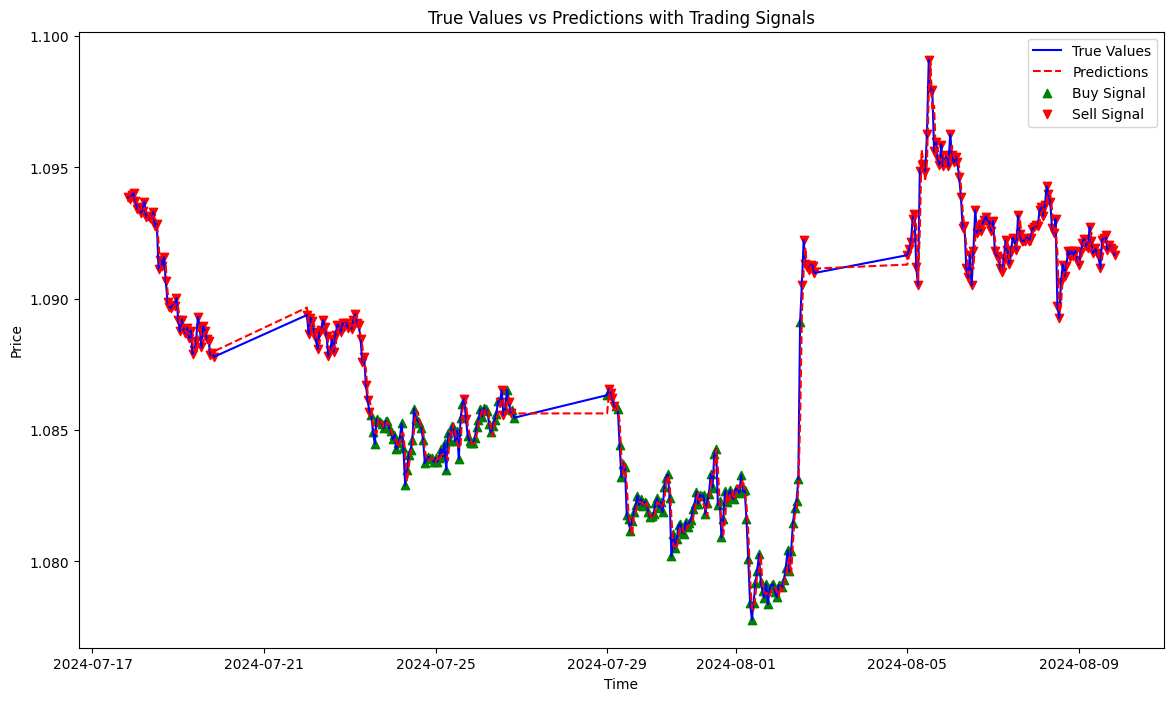

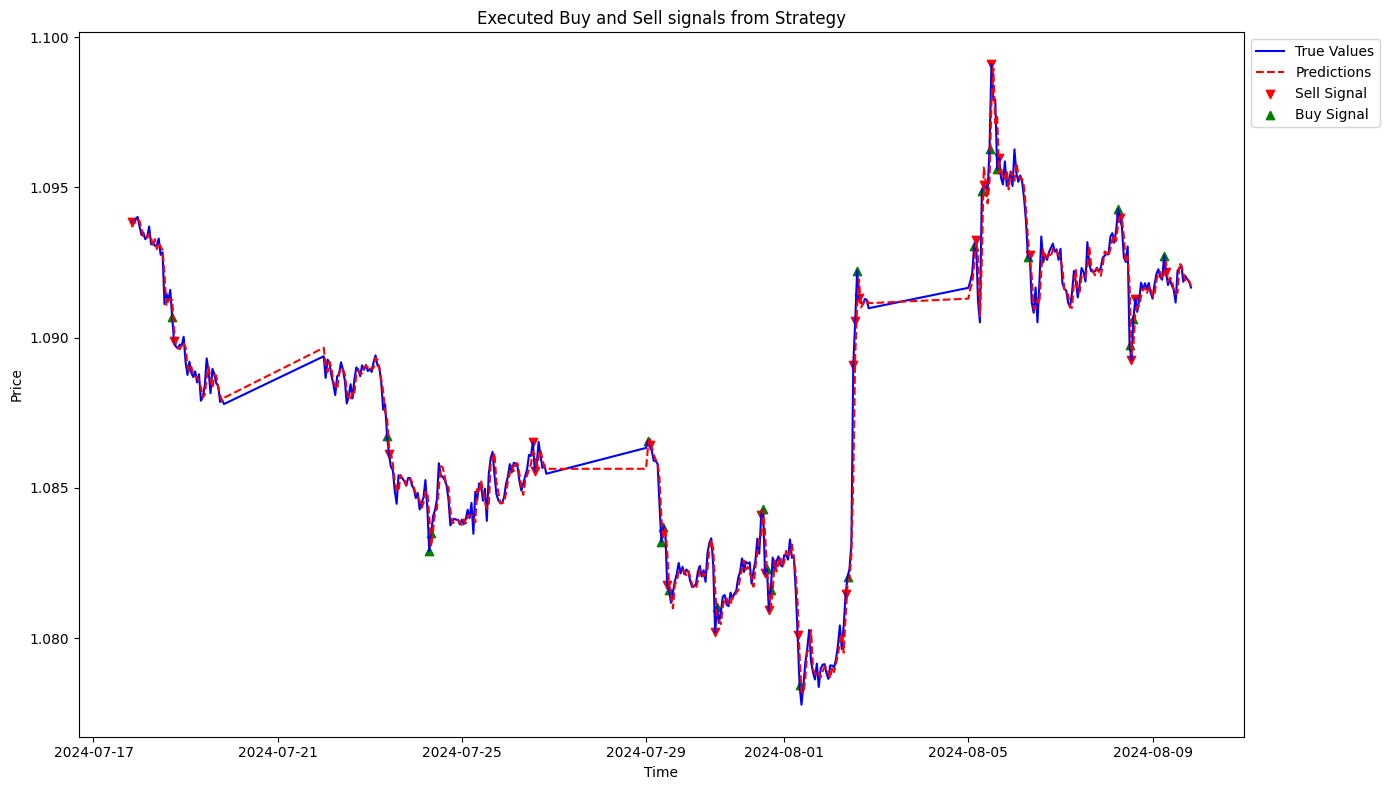

In [92]:
# Main function to run the model
def main():
    # Load data
    file_path = './Data/EURUSD_H1.csv'  # Replace with your CSV file path
    X, y, time = load_data(file_path)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

    print(X_train.head())

   # Standardize features - unless volume added, not needed
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    # Initialize and train the model
    model = LinearRegression(learning_rate=0.01, n_iterations=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Evaluate the model
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)

    print(f'Training MSE: {train_mse}')
    print(f'Test MSE: {test_mse}')

    print(f"The test predictions: \n{y_pred_test}")
   # Generate sinals: Initialize lists to store signals
    buy_signals = []
    sell_signals = []
    entry_prices = []

    # Prediction to be based on the previous time step closing/openinng price
    for i in range(len(y_pred_test)):  
        if y_pred_test[i] > X_test[i][0]:  # for the current timeStep if Predicted close > open (long position signal)
            buy_signals.append((time_test.values[i], y_test.values[i]))  # Save time and price
            sell_signals.append((np.nan, np.nan))  # No sell signal
            entry_prices.append(y_test.values[i])  # Store entry price for long position
        elif y_pred_test[i] < X_test[i][0]:  # Predicted close < open (short position signal)
            sell_signals.append((time_test.values[i], y_test.values[i]))  # Save time and price
            buy_signals.append((np.nan, np.nan))  # No buy signal
            entry_prices.append(y_test.values[i])  # Store entry price for short position
        else:
            buy_signals.append((np.nan, np.nan))  # No signal
            sell_signals.append((np.nan, np.nan))  # No signal
            entry_prices.append(np.nan)  # No entry price

    # Separate time and price for plotting
    buy_times = [signal[0] for signal in buy_signals if not np.isnan(signal[0])]
    buy_prices = [signal[1] for signal in buy_signals if not np.isnan(signal[1])]
    sell_times = [signal[0] for signal in sell_signals if not np.isnan(signal[0])]
    sell_prices = [signal[1] for signal in sell_signals if not np.isnan(signal[1])]

    # Simulate trades and evaluate performance
    cumulative_pips, trade_entries = simulate_trades(time_test, y_test, y_pred_test, X_test)
    print(f'Cumulative Pips Gained/Lost: {cumulative_pips}')

    # Plot results -  Good Skripie to show more trading opportunity
    plt.figure(figsize=(14, 8))
    plt.plot(time_test.values, y_test, color='blue', label='True Values')
    plt.plot(time_test.values, y_pred_test, color='red', linestyle='--', label='Predictions')
    plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
    plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('True Values vs Predictions with Trading Signals')
    plt.legend()
    plt.show()

   # Plot results
    plt.figure(figsize=(14, 8))  # Make the plot larger to avoid crowding
    plt.plot(time_test.values, y_test, color='blue', label='True Values')
    plt.plot(time_test.values, y_pred_test, color='red', linestyle='--', label='Predictions')

    # Plot trade signals
    buy_plotted = False
    sell_plotted = False
    for entry in trade_entries:
        if entry[2] == 'Buy':
            if not buy_plotted:  # Plot buy signals with label only once
                plt.scatter(entry[0], entry[1], marker='^', color='green', label='Buy Signal', alpha=1)
                buy_plotted = True
            else:
                plt.scatter(entry[0], entry[1], marker='^', color='green', alpha=1)
        elif entry[2] == 'Sell':
            if not sell_plotted:  # Plot sell signals with label only once
                plt.scatter(entry[0], entry[1], marker='v', color='red', label='Sell Signal', alpha=1)
                sell_plotted = True
            else:
                plt.scatter(entry[0], entry[1], marker='v', color='red', alpha=1)

    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Executed Buy and Sell signals from Strategy')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside the plot
    plt.tight_layout()  # Adjust the plot to make room for the legend
    plt.show()
if __name__ == '__main__':
    main()


# PREVIOUS ENTRY AND EXIT TRADE SIMULATION

In [ ]:
# Initialize variables for backtesting
capital = 100000  # Starting capital in dollars (or any unit)
position = None  # Keeps track of the current position ('long', 'short', or None)
entry_price = 0  # The price at which the position was entered
pips_per_trade = 0  # To track pips gained/lost in each trade
cumulative_pips = 0  # To track cumulative pips gained/lost over time
pips_list = []  # Track pips gained/lost per trade

entry_points = []  # Track entry points for plotting
exit_points = []  # Track exit points for plotting

# Define take profit and stop loss (in pips)
take_profit_pips = 50
stop_loss_pips = 30

# Convert pips to actual price movement for EURUSD (1 pip = 0.0001)
pip_value = 0.0001

for i in range(len(y_test)):
    # Buy Signal (Enter Long)
    if buy_signals[i][0] is not None and position is None:
        position = 'long'
        entry_price = y_test.iloc[i]  # Enter at the current price

        entry_time = time_test.iloc[i]
        entry_points.append((entry_time, entry_price))  # Track entry point


    # Sell Signal (Enter Short)
    elif sell_signals[i][0] is not None and position is None:
        position = 'short'
        entry_price = y_test.iloc[i]  # Enter at the current price

        entry_time = time_test.iloc[i]
        entry_points.append((entry_time, entry_price))  # Track entry point


    # Exit Long Position
    elif position == 'long':
        # Calculate pips gained
        price_diff = y_test.iloc[i] - entry_price
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point
            position = None  # Exit position after trade

    # Exit Short Position
    elif position == 'short':
        # Calculate pips gained (inverse for short position)
        price_diff = entry_price - y_test.iloc[i]
        pips_per_trade = price_diff / pip_value

        # Check if take profit or stop loss is hit
        if pips_per_trade >= take_profit_pips or pips_per_trade <= -stop_loss_pips:
            cumulative_pips += pips_per_trade
            pips_list.append(pips_per_trade)
            exit_points.append((time_test.iloc[i], y_test.iloc[i]))  # Track exit point

            position = None  # Exit position after trade

# After the loop: Plotting the results

# Extract entry and exit times and prices for plotting
entry_times = [point[0] for point in entry_points]
entry_prices = [point[1] for point in entry_points]
exit_times = [point[0] for point in exit_points]
exit_prices = [point[1] for point in exit_points]

# Plot the price chart with entry and exit points
plt.figure(figsize=(14, 7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='orange', linestyle='-')

# Plot buy and sell signals
plt.scatter(entry_times, entry_prices, marker='^', color='green', label='Entry Point', alpha=1, s=100)
plt.scatter(exit_times, exit_prices, marker='v', color='red', label='Exit Point', alpha=1, s=100)

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Price Chart with Trade Entry and Exit Points')
plt.legend()
plt.grid(True)
plt.show()

# After the loop: Analyze the strategy performance
total_trades = len(pips_list)
winning_trades = len([p for p in pips_list if p > 0])
losing_trades = total_trades - winning_trades
win_rate = winning_trades / total_trades if total_trades > 0 else 0

# Display the backtesting results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Cumulative Pips: {cumulative_pips:.2f}")

